In [23]:
import numpy as np
import pandas as pd
from sqlalchemy import or_

from app.models import Session, Headline, Article, Agency
from app.utils import Country, Config

In [24]:
s = Session()
data = s.query(
    Headline.id, Article.id, Agency.name, Headline.processed, Headline.first_accessed, Headline.last_accessed
).join(Headline.article).join(Article.agency).filter(
    or_(Agency._country == Country.us.value, Agency.name.in_(Config.exempted_foreign_media))
).all()
s.close()

In [25]:
raw_df = pd.DataFrame(data, columns=['hid', 'aid', 'agency', 'title', 'first', 'last'])
print(raw_df.shape)

(720502, 6)


In [26]:
from tqdm import tqdm

tqdm.pandas()
# Take only the first 1000 rows for now
# df = raw_df.head(10000).copy()
df = raw_df.copy()
# Convert the datetimes from utc to NY time. They're not timezone aware
df['first'] = df['first'].dt.tz_localize('utc').dt.tz_convert('America/New_York')
df['last'] = df['last'].dt.tz_localize('utc').dt.tz_convert('America/New_York')
# Get the timedelta between the first and last access
df['delta'] = df['last'] - df['first']
# Drop the rows where the delta is more than 3 days. This should filter out normal links not to real stories
df = df[df['delta'] <= pd.Timedelta(days=3)]

In [27]:
# filtering by us and exempted media really improves this!
def get_hours(row):
    first = row['first']
    last = row['last']
    # Zero out the minutes and seconds
    first_ts = first.replace(minute=0, second=0, microsecond=0).timestamp()
    last_ts = last.replace(minute=0, second=0, microsecond=0).timestamp()
    # get every half hour between the first and last access
    hours = np.arange(first_ts, last_ts, 1800, dtype=int)
    # Filter out the hours that are not in the same day as the first access
    return hours[(hours <= last_ts) & (hours >= first_ts)]
    
df['halfhour'] = df.progress_apply(get_hours, axis=1)

100%|██████████| 682300/682300 [00:21<00:00, 31443.60it/s]


In [28]:
# Next we explode the hours column so that each row corresponds to a single hour
df = df.explode('halfhour')
# Reset the index
df.reset_index(drop=True, inplace=True)
# Convert the hours column to a datetime
df['halfhour'] = pd.to_datetime(df['halfhour'], unit='s')
df = df[['title', 'halfhour']]

In [29]:
df.sample(5)

,title,halfhour
1623925,Adam Sandler admits Taylor Swift makes him ner...,2024-02-28 23:00:00
9796250,"Biden Makes Bizarre Remark About Schumer, and ...",2024-04-26 05:30:00
218897,500-gallon underground propane tank found at V...,2024-02-17 21:00:00
4083429,George Santos takes random swipe at Taylor Swi...,2024-03-16 20:30:00
9492310,'Very Mafioso': Watergate prosecutor slams Tru...,2024-04-24 04:30:00


In [30]:
# Group by the hours column and apply the get_newsiness function to the titles
# Eventually we can speed this up with multiprocessing I think.
# For now though, this is fine. More than a million headlines Seems to be taking under 20 minutes.
# Recalculation will be expensive! But we won't do it often.
# We'll save the results as a csv for incorporation in the website.
# Simple solutions are best.

import multiprocessing as mp
from app.analysis.newsiness import get_newsiness

titles_by_hour = [group["title"].tolist() for _, group in df.groupby('halfhour')]
with mp.Pool(mp.cpu_count()) as pool:
    results = pool.imap(get_newsiness, titles_by_hour)
    newsiness = list(tqdm(results, total=len(titles_by_hour)))


# It took almost 22 minutes for the first run.
# newsiness = df.groupby('hours')['title'].progress_apply(get_newsiness)


100%|██████████| 4838/4838 [00:53<00:00, 90.72it/s] 


In [42]:
# Create a dataframe from the groupby object and add a column of the newsiness
newsiness_df = df.groupby('halfhour').first().reset_index()
newsiness_df = newsiness_df[['halfhour']]
newsiness_df['newsiness'] = newsiness
newsiness_df.head()

,halfhour,newsiness
0,2024-02-16 20:00:00,2.750258
1,2024-02-16 20:30:00,2.750258
2,2024-02-16 21:00:00,2.501889
3,2024-02-16 21:30:00,2.501889
4,2024-02-16 22:00:00,2.610354


In [43]:
# Get some statistics
newsiness_df['newsiness'].describe()

count    4838.000000
mean        2.200360
std         0.691717
min         1.100894
25%         1.732549
50%         2.010163
75%         2.492280
max         7.202365
Name: newsiness, dtype: float64

In [44]:
# Let's sample some headlines from the highest newsiness hour
df[df['halfhour'] == newsiness_df[newsiness_df['newsiness'] == newsiness_df['newsiness'].max()]['halfhour'].values[0]].sample(10)

,title,halfhour
13888891,The Middle East is roiling -- the death of Ira...,2024-05-20 15:00:00
13440125,Michael Cohen's testimony to wrap up as Trump ...,2024-05-20 15:00:00
13804149,Power Restored to Most Affected by Deadly Hous...,2024-05-20 15:00:00
13839785,Value investor Bill Nygren thinks financials a...,2024-05-20 15:00:00
13808381,Lil Nas X: I felt like an imposter on tour,2024-05-20 15:00:00
13801014,The value of silence Under The Radar In a worl...,2024-05-20 15:00:00
13875510,US pediatricians group reverses decades-old po...,2024-05-20 15:00:00
13831264,TikTok-owner ByteDance takes the lead in the r...,2024-05-20 15:00:00
13482851,'Extremely Alarmed': Strategists Break Down Ma...,2024-05-20 15:00:00
13873947,"Toddler shot in face in Minneapolis shooting, ...",2024-05-20 15:00:00


In [45]:
# Now create a column of the day of the week
newsiness_df['day'] = newsiness_df['halfhour'].dt.day_name()
# Convert the "hours" column, which is actually halfhour to the hour of the day to an integer representing the 24 hour clock (00, 30, 60, 90, etc)
newsiness_df['halfhour'] = newsiness_df['halfhour'].dt.hour * 60 + newsiness_df['halfhour'].dt.minute

# Create a df of group by hour and day and take the mean of the newsiness and the median of the newsiness
newsiness_df = newsiness_df.groupby(['halfhour', 'day'])['newsiness'].agg(['mean', 'median', 'std']).reset_index()
newsiness_df.head()

,halfhour,day,mean,median,std
0,0,Friday,1.942678,1.883297,0.522981
1,0,Monday,2.410457,2.325975,0.622616
2,0,Saturday,2.407826,2.154275,0.735628
3,0,Sunday,2.225565,2.126182,0.611258
4,0,Thursday,2.200948,2.055531,0.591653


In [46]:
newsiness_df.to_csv('../newsiness.csv', index=False)

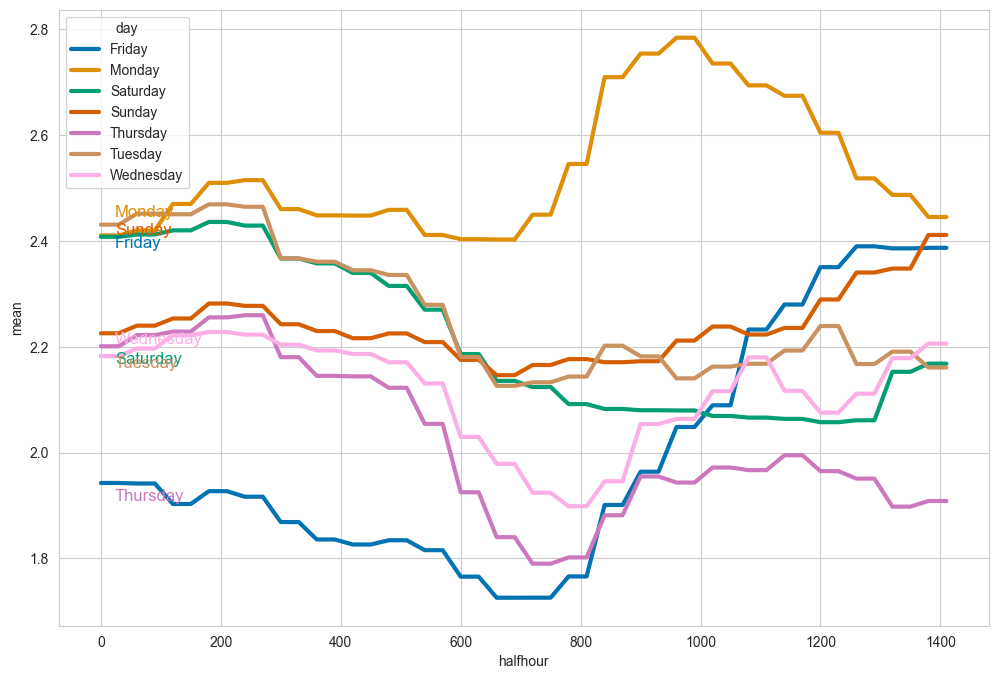

In [35]:
# Plot the mean newsiness by hour
import seaborn as sns
import matplotlib.pyplot as plt

# Colorblind friendly
sns.set_palette('colorblind')
plt.figure(figsize=(12, 8))
sns.lineplot(data=newsiness_df, x='halfhour', y='mean', hue='day', lw=3)
# Add annotations for the days
for i, day in enumerate(newsiness_df['day'].unique()):
    plt.text(23, newsiness_df[newsiness_df['day'] == day]['mean'].values[-1], day, fontsize=12,
             color=sns.color_palette('colorblind')[i])
plt.show()

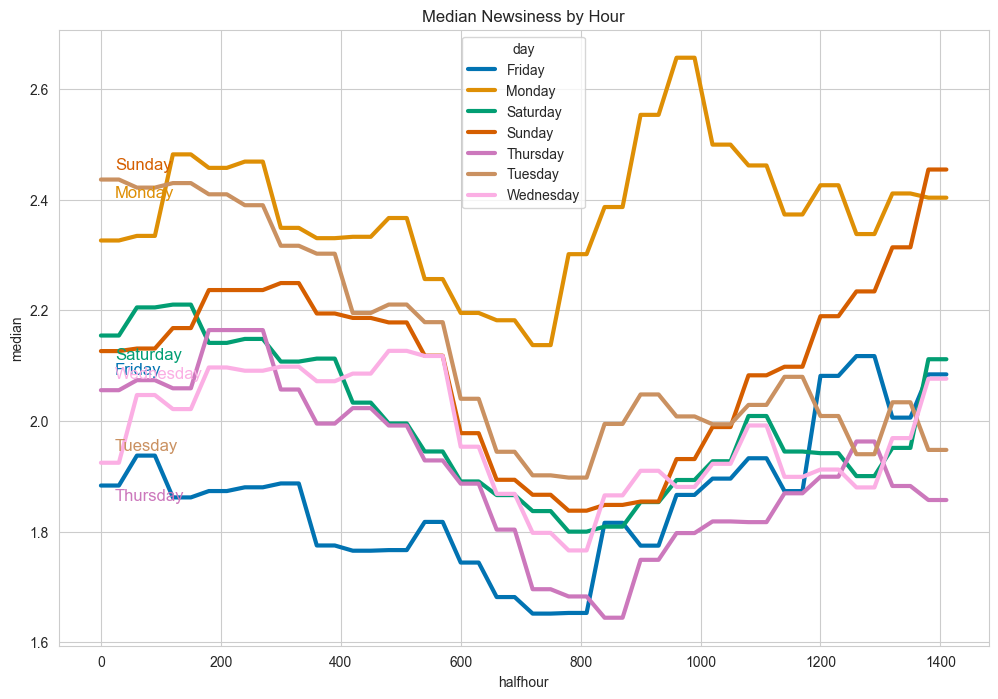

In [36]:
# Plot the median newsiness by hour
plt.figure(figsize=(12, 8))
sns.lineplot(data=newsiness_df, x='halfhour', y='median', hue='day', lw=3)
# Add a title
plt.title('Median Newsiness by Hour')
# Add annotations for the days
for i, day in enumerate(newsiness_df['day'].unique()):
    plt.text(23, newsiness_df[newsiness_df['day'] == day]['median'].values[-1], day, fontsize=12,
             color=sns.color_palette('colorblind')[i])
plt.show()


In [37]:
# Rank the days by newsiness
newsiness_df.groupby('day')['mean'].mean().sort_values(ascending=False)

day
Monday       2.531605
Tuesday      2.264327
Sunday       2.237751
Saturday     2.215528
Wednesday    2.117355
Thursday     2.025305
Friday       1.992700
Name: mean, dtype: float64

In [39]:
# Rank the hours by newsiness
newsiness_df.groupby('halfhour')['mean'].mean().sort_values(ascending=False)

halfhour
180     2.301071
210     2.301071
240     2.297893
270     2.297893
120     2.278187
150     2.278187
60      2.269141
90      2.269141
0       2.257233
30      2.257233
300     2.241397
330     2.241397
1380    2.241023
1410    2.241023
1350    2.234411
1320    2.234411
1200    2.225988
1230    2.225988
360     2.224352
390     2.224352
1140    2.222634
1170    2.222634
1260    2.219895
1290    2.219895
1110    2.218686
1080    2.218686
450     2.215029
420     2.215029
510     2.208923
480     2.208923
1020    2.197534
1050    2.197534
960     2.181654
990     2.181654
570     2.167183
540     2.167183
930     2.165952
900     2.165952
870     2.127624
840     2.127624
630     2.095209
600     2.095209
810     2.060625
780     2.060625
690     2.050822
660     2.050822
750     2.044633
720     2.044633
Name: mean, dtype: float64

In [40]:
# Find the newsiest hourday
newsiness_df[newsiness_df['mean'] == newsiness_df['mean'].max()]

,halfhour,day,mean,median,std
225,960,Monday,2.784025,2.656131,1.27527
232,990,Monday,2.784025,2.656131,1.27527


In [41]:
# Group by morning, afternoon, evening, night and find the busiest period on which day
newsiness_df['period'] = pd.cut(newsiness_df['halfhour'], bins=[v * 60 for v in [0, 6, 12, 18, 24]],
                                labels=['night', 'morning', 'afternoon', 'evening'])
newsiness_df.groupby(['day', 'period'])['mean'].mean().sort_values(ascending=False)

C:\Users\malan\AppData\Local\Temp\ipykernel_26808\2141284694.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  newsiness_df.groupby(['day', 'period'])['mean'].mean().sort_values(ascending=False)


day        period   
Monday     afternoon    2.683329
           evening      2.559300
           night        2.467359
Tuesday    night        2.433107
Monday     morning      2.428836
Saturday   night        2.407764
Friday     evening      2.347181
Sunday     evening      2.315651
           night        2.253810
Tuesday    morning      2.252266
Saturday   morning      2.247894
Thursday   night        2.219900
Wednesday  night        2.210185
Sunday     morning      2.194945
           afternoon    2.194107
Tuesday    evening      2.188221
           afternoon    2.163496
Wednesday  evening      2.141572
Saturday   evening      2.097534
Wednesday  morning      2.092503
Saturday   afternoon    2.083063
Wednesday  afternoon    2.021763
Thursday   morning      2.008994
Friday     afternoon    1.958059
Thursday   evening      1.945642
Friday     night        1.907771
Thursday   afternoon    1.905407
Friday     morning      1.791498
Name: mean, dtype: float64